In [ ]:
#install hugging face evaluate 
!pip install evaluate 

In [ ]:
# install transformers 
!pip install transformers

In [4]:
#imports 

import pandas as pd
import numpy as np
import json
import re
import string
from textwrap import wrap


from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


import transformers
from transformers import DistilBertTokenizerFast

import seaborn as sns
import matplotlib.pyplot as plt

from transformers import TrainingArguments, Trainer
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from transformers import TextClassificationPipeline
#from transformers import pipeline
from huggingface_hub import notebook_login

import evaluate

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score  

from sklearn.metrics import confusion_matrix, classification_report  
%matplotlib inline


In [5]:
#mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Model (**English_BERT**)

In [6]:
# 3 datasets
train_seg = pd.read_csv('/content/drive/MyDrive/IM/VTPAN_csv/train_seg.csv')
val_seg = pd.read_csv('/content/drive/MyDrive/IM/VTPAN_csv/val_seg.csv')
test_seg = pd.read_csv('/content/drive/MyDrive/IM/VTPAN_csv/test_seg.csv')


In [7]:
print(f'train dataset', train_seg.shape)
print(f'val dataset', val_seg.shape)
print(f'test dataset', test_seg.shape)

train dataset (4611, 2)
val dataset (1977, 2)
test dataset (15329, 2)


In [59]:
#number of tokens in training data 
token_lens = []
for txt in train_seg['segment']:
  tokens = tokenizer.encode(txt, truncation=True, max_length=3500)
  token_lens.append(len(tokens))

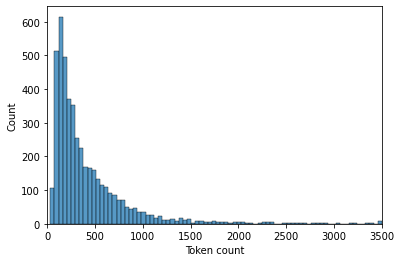

In [61]:
sns.histplot(token_lens)
plt.xlim([0, 3500]);
plt.xlabel('Token count');

In [62]:
#number of tokens in training data 
token_lens = []
for txt in test_seg['segment']:
  tokens = tokenizer.encode(txt, truncation=True, max_length=3500)
  token_lens.append(len(tokens))

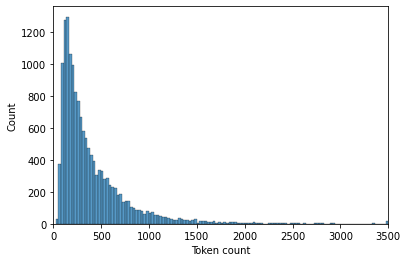

In [63]:
sns.histplot(token_lens)
plt.xlim([0, 3500]);
plt.xlabel('Token count');

In [57]:
test_seg.head(152)

,segment,label
0,back ok babe what happend babe dog wanted out ...,1
1,hello boys are shit that they are hi sorry i w...,0
2,"hi 19 m usa horny, u? 2+2*2 2+2*2? 6? yay now ...",0
3,f/m ? hi there f u? hi m 18 nice ireland u ? u...,0
4,"sorry, I'm back now. and for the record I want...",0
...,...,...
147,? ?? hello~~~~~~~~~~~~~~~~~~ hi hahahahahahaha...,0
148,Penis? hi yes u? Are you gay? nop Lol cool i h...,0
149,hey hi asi 19 hey hey f 18 m where u frm wait ...,0
150,hey how's my sexy little slut? good hpw r u ho...,1


In [12]:
#load tokenizer and model 
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

model = AutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'pre_classifier.bias', 'classifier

In [13]:
#data to list
X_train = list(train_seg["segment"])
y_train = list(train_seg["label"])
X_val = list(val_seg["segment"])
y_val = list(val_seg["label"])
X_test = list(test_seg["segment"])
y_test = list(test_seg["label"])

In [14]:
#tokenize 
train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
val_encodings = tokenizer(X_val, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=512)


In [15]:
# Create torch dataset
class Dataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels=None):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.encodings["input_ids"])

In [16]:
#load the 3 dataset
train_dataset_S = Dataset(train_encodings, y_train)
val_dataset_S = Dataset(val_encodings, y_val)
test_dataset_S = Dataset(test_encodings, y_test)

In [17]:
# Define Trainer
args = TrainingArguments(
    output_dir="IM_seg",
    num_train_epochs=3,
    per_device_train_batch_size=16

)
trainer = Trainer(
    model=model,
    args=args,
    tokenizer=tokenizer,
    train_dataset=train_dataset_S,
    eval_dataset=val_dataset_S)

In [18]:
#train
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,0.064900


TrainOutput(global_step=867, training_loss=0.042425980617430796, metrics={'train_runtime': 684.8323, 'train_samples_per_second': 20.199, 'train_steps_per_second': 1.266, 'total_flos': 1832421525608448.0, 'train_loss': 0.042425980617430796, 'epoch': 3.0})

In [ ]:
#evaluate on validation data 
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1977
  Batch size = 8


{'eval_loss': 0.05145983397960663,
 'eval_runtime': 30.477,
 'eval_samples_per_second': 64.869,
 'eval_steps_per_second': 8.137,
 'epoch': 3.0}

In [ ]:
#push model to hub
trainer.push_to_hub()

**Test monolingual EnglishBERT on English test data**

In [19]:
#get prediction from test data 
predictions = trainer.predict(test_dataset_S)
preds = np.argmax(predictions.predictions, axis=-1)

In [ ]:
# macro f1 on test data 
metric = evaluate.load("f1")
metric.compute(predictions=preds, references=y_test,  average="macro")

{'f1': 0.9869531421872406}

In [49]:
class_names = [ 'non_predator', 'predator']

In [24]:
#classification report

print(classification_report(y_test, preds, target_names=class_names))

              precision    recall  f1-score   support

non_predator       1.00      1.00      1.00     13863
    predator       0.98      0.96      0.97      1466

    accuracy                           0.99     15329
   macro avg       0.99      0.98      0.98     15329
weighted avg       0.99      0.99      0.99     15329



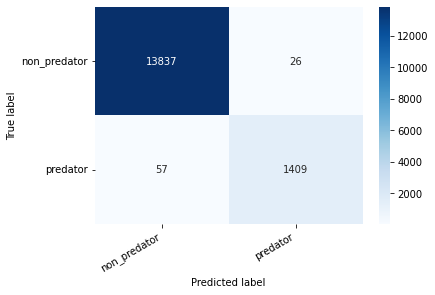

In [23]:
#confusion matrix 
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True label')
  plt.xlabel('Predicted label');
cm = confusion_matrix(y_test, preds)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [25]:
#missclassified examples 
misclassified = np.where(preds != y_test)
print(misclassified)

(array([   30,   150,   729,   835,   970,   983,  1723,  2005,  2041,
        2087,  2456,  3013,  3434,  4426,  4515,  4556,  4622,  4660,
        5042,  5062,  5079,  5371,  5535,  5633,  5762,  5928,  5956,
        6027,  6246,  6289,  6362,  6372,  6599,  6952,  7015,  7080,
        7462,  7540,  7614,  7629,  7680,  7850,  7877,  7881,  7917,
        8478,  8490,  9072,  9105,  9225,  9545,  9699,  9756,  9768,
        9902, 10095, 10381, 10590, 10649, 10799, 10945, 11446, 11762,
       11972, 12127, 12192, 12195, 12263, 12362, 12462, 12860, 13018,
       13137, 13261, 13382, 13467, 13605, 13628, 13826, 13933, 14885,
       15143, 15167]),)


In [54]:
#example from the test data and its true and predicted labels
idx = 150
review_text = test_seg['segment'][idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': preds[idx]
}) 
print("\n".join(wrap(review_text)))
print()
print(f'True label: {class_names[true_sentiment]}')
print()
print(f'Predicted label: {preds[idx]}')


hey how's my sexy little slut? good hpw r u horny hehe u always r
wishing I could fuck you in the ass right now hehe want to do pics
with you in skirts with my cum running out of your holes do i? yes
you'd like that? yes dripping out of your pussy and ass? hehe yes
fingering both holes after in the pics too, then licking them clean ur
such a bad boy :D bet you'd love doing that in pics and on film wit u
i woudl you ever fingered your ass before? i did a lil the other nite
when u told me to it was kinda good got you wet? a lil think you could
cum from it? nah u busy no. what's on your mind? nuttin just wondering
ur kinda quiet what do you wish I were doing to you right now? making
me ur slave raping you even? yes fucking you to tears? i wont cry I
think you might when I'm in your ass nuh uh not me :) think you might,
I'm gonna just force it all in haha well see the fun way hopefullty
somday I would cum so hard if you were crying on my dick u want me to
cry yeah i will if it will make u 

In [64]:
#Test on raw text 
text = ["iam 23 guy from NYC, u? i am 13, girl. do u like older guys?"]
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=0)
pipe(text)

[{'label': 'LABEL_0', 'score': 0.9998866319656372}]

In [ ]:
#Test on raw text 
text = ["iam 23 from NYC, u? i am 13. do u like older guys?"]
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, device=0)
pipe(text)

In [8]:
#load model
tokenizer_IM = AutoTokenizer.from_pretrained("Constien/IM_Model")

model_IM = AutoModelForSequenceClassification.from_pretrained("Constien/IM_Model")